# LSTM recipe generator training

Note: This notebook is desinged to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the recipe dataset.

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.4 MB/s eta 0:00:00


Import modules and set random seeds.

In [2]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [3]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

Vocabulary size: 30522


Download the recipe dataset and extract directions texts.

In [4]:
from datasets import load_dataset
recipe = load_dataset('Shengtao/recipe')

def join_title_and_directions(title_directions):
    title, directions = title_directions
    return 'Recipe for {}: {}'.format(title, directions)

recipe_texts = list(map(join_title_and_directions,
                        zip(recipe['train']['title'], recipe['train']['directions'])))
recipe_texts = recipe_texts[::4] # Select 25% of the entire training set.

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/Shengtao___csv/Shengtao--recipe-3a76906d12322926/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
recipe_texts[0]

'Recipe for Simple Macaroni and Cheese: Bring a large pot of lightly salted water to a boil. Cook elbow macaroni in the boiling water, stirring occasionally until cooked through but firm to the bite, 8 minutes. Drain. Melt butter in a saucepan over medium heat; stir in flour, salt, and pepper until smooth, about 5 minutes. Slowly pour milk into butter-flour mixture while continuously stirring until mixture is smooth and bubbling, about 5 minutes. Add Cheddar cheese to milk mixture and stir until cheese is melted, 2 to 4 minutes. Fold macaroni into cheese sauce until coated.'

Check the distribuion of the text length.

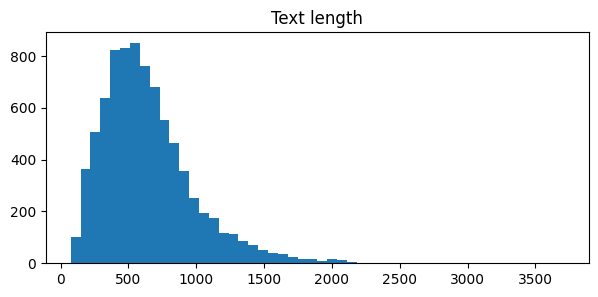

In [6]:
fig = plt.figure(figsize=(7, 3))
subplot = fig.add_subplot(1,1,1)
subplot.set_title('Text length')
_ = subplot.hist(list(map(lambda x: len(x), recipe_texts)), bins=50)

Create the training and test datasets, truncating long texts into 512 words.

In [7]:
MAX_LEN = 512

train_set, test_set = train_test_split(recipe_texts, test_size=0.1)

train_set = tokenizer(train_set, max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])[:, :-1]
train_label = np.array(train_set['input_ids'])[:, 1:]

test_set = tokenizer(test_set, max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])[:, :-1]
test_label = np.array(test_set['input_ids'])[:, 1:]

Define the LSTM model.

In [8]:
lstm_model = models.Sequential(name='LSTM_next_word_predictor')
lstm_model.add(layers.Embedding(VOCAB_SIZE, 512, input_shape=(None,), name='text_embedding'))
lstm_model.add(layers.LSTM(512, return_sequences=True, name='LSTM_cell'))
lstm_model.add(layers.Dense(VOCAB_SIZE, activation='softmax', name='softmax'))

lstm_model.summary()

Model: "LSTM_next_word_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (Embedding)  (None, None, 512)         15627264  
                                                                 
 LSTM_cell (LSTM)            (None, None, 512)         2099200   
                                                                 
 softmax (Dense)             (None, None, 30522)       15657786  
                                                                 
Total params: 33,384,250
Trainable params: 33,384,250
Non-trainable params: 0
_________________________________________________________________


Compile the model using the Adam optimizer, and the sparse categorical crossentroy as a loss function.

In [9]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['acc'])

Train the model.

In [10]:
%%time
history = lstm_model.fit(train_text, train_label,
                         validation_data=(test_text, test_label),
                         batch_size=8, epochs=5)

Epoch 1/5
921/921 [==============================] - 269s 280ms/step - loss: 1.5513 - acc: 0.7625 - val_loss: 0.9378 - val_acc: 0.8234
Epoch 2/5
921/921 [==============================] - 237s 257ms/step - loss: 0.8139 - acc: 0.8400 - val_loss: 0.7555 - val_acc: 0.8479
Epoch 3/5
921/921 [==============================] - 235s 255ms/step - loss: 0.6953 - acc: 0.8550 - val_loss: 0.6930 - val_acc: 0.8558
Epoch 4/5
921/921 [==============================] - 235s 255ms/step - loss: 0.6375 - acc: 0.8624 - val_loss: 0.6614 - val_acc: 0.8600
Epoch 5/5
921/921 [==============================] - 233s 253ms/step - loss: 0.5985 - acc: 0.8674 - val_loss: 0.6418 - val_acc: 0.8632
CPU times: user 7min 24s, sys: 3min 10s, total: 10min 34s
Wall time: 20min 8s


Mount the google drive and save the trained model.

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

lstm_model.save('/content/gdrive/My Drive/LSTM_recipe_generator.hd5', save_format='h5')

Mounted at /content/gdrive


In [12]:
ls -lh '/content/gdrive/My Drive/LSTM_recipe_generator.hd5'

-rw------- 1 root root 383M Jul 23 11:34 '/content/gdrive/My Drive/LSTM_recipe_generator.hd5'
